In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from boruta import BorutaPy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
df = pd.read_csv('data/houses_Madrid_cleaned.csv')

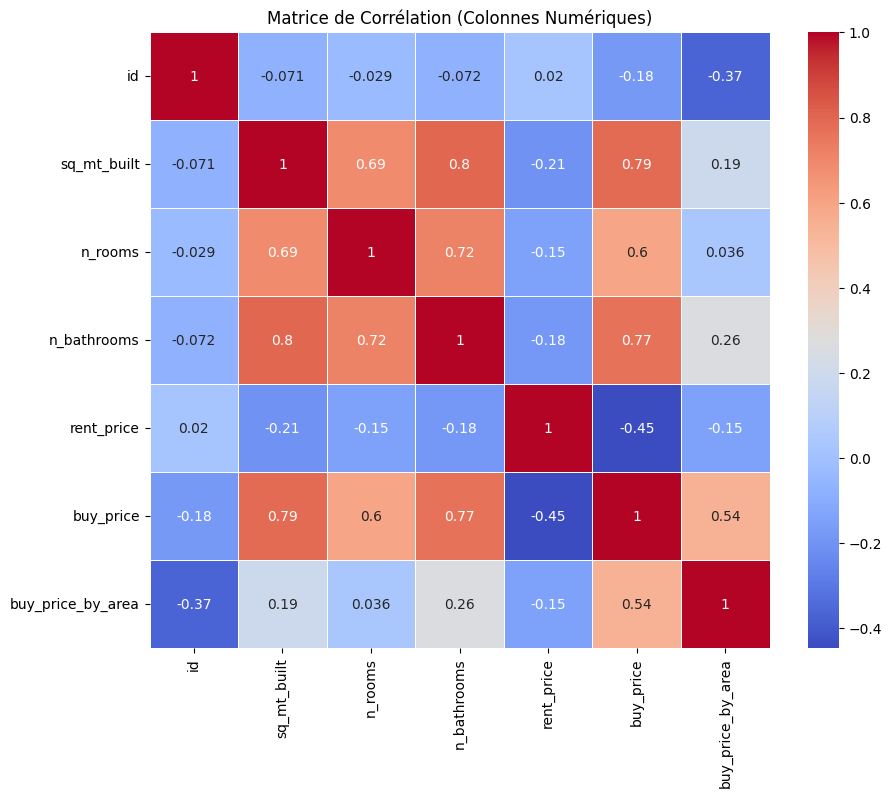

In [3]:
# Filtrer uniquement les colonnes numériques
numeric_df = df.select_dtypes(include=[np.number])

# Calculer et afficher la matrice de corrélation uniquement pour les colonnes numériques
correlation_matrix = numeric_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matrice de Corrélation (Colonnes Numériques)')
plt.show()

## Traitement

In [7]:
# Séparation des caractéristiques et de la cible
caracteristiques = [
    'sq_mt_built',
    'n_rooms',
    'n_bathrooms',
    'buy_price_by_area',
    'has_lift',
    'is_exterior',
    'has_parking',
    'is_new_development',
    'has_central_heating',
    'has_individual_heating',
    'has_ac',
    'has_fitted_wardrobes'
]

X = df[caracteristiques]
y = df['buy_price']

# Remplir les valeurs manquantes
X.fillna(0, inplace=True)
y.fillna(y.mean(), inplace=True)

# Encodage des variables catégorielles
X_encode = pd.get_dummies(X, drop_first=True)

# Division en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_encode, y, test_size=0.3)

# Prétraitement des données
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), X_encode.select_dtypes(include=['float64', 'int64']).columns),
    ('cat', OneHotEncoder(handle_unknown='ignore'), X_encode.select_dtypes(include=['object']).columns)
])

C:\Users\QWERTY\AppData\Local\Temp\ipykernel_8688\2024549646.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)


## Regression Rigide

In [5]:
# Algorithme 1 : Ridge Regression
def ridge_regression():
    print("Entraînement du modèle Ridge...")
    model = Ridge()
    param_grid = {'alpha': [0.1, 1.0, 10.0, 100.0]}
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    # Prédiction et évaluation
    y_pred_r = best_model.predict(X_test)
    
    # Calcul des métriques
    mse = mean_squared_error(y_test, y_pred_r)
    rmse = np.sqrt(mse)  # Root Mean Square Error
    mae = mean_absolute_error(y_test, y_pred_r)  # Mean Absolute Error
    mape = np.mean(np.abs((y_test - y_pred_r) / y_test)) * 100  # Mean Absolute Percentage Error
    r2 = r2_score(y_test, y_pred_r)  # R-squared

    # Affichage des résultats
    print(f"Meilleurs hyperparamètres : {grid_search.best_params_}")
    print(f'MSE : {mse}')
    print(f'RMSE : {rmse}')
    print(f'MAE : {mae}')
    print(f'MAPE : {mape}%')
    print(f'R² : {r2}\n')

ridge_regression()

Entraînement du modèle Ridge...
Meilleurs hyperparamètres : {'alpha': 10.0}
MSE : 85025090708.20605
RMSE : 291590.62177684327
MAE : 162290.55211787473
MAPE : 43.643648391708%
R² : 0.8295376308597484



## Boruta Forest

In [6]:
# Algorithme 2 : Random Forest avec Boruta
def random_forest_boruta():
    print("Entraînement du modèle RandomForest avec Boruta...")
    rf = RandomForestRegressor(n_estimators=200, n_jobs=-1)
    boruta_selector = BorutaPy(estimator=rf, n_estimators='auto', max_iter=30)

    # Appliquer Boruta
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    boruta_selector.fit(X_train_scaled, y_train)
    selected_features = X_encode.columns[boruta_selector.support_]

    # Utiliser les caractéristiques sélectionnées
    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]

    # GridSearchCV pour RandomForest
    rf_model = RandomForestRegressor()
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'bootstrap': [True, False]
    }

    grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train_selected, y_train)

    # Prédiction et évaluation
    y_pred_br = grid_search.best_estimator_.predict(X_test_selected)
    
    # Calcul des métriques
    mse = mean_squared_error(y_test, y_pred_br)
    rmse = np.sqrt(mse)  # Root Mean Square Error
    mae = mean_absolute_error(y_test, y_pred_br)  # Mean Absolute Error
    mape = np.mean(np.abs((y_test - y_pred_br) / y_test)) * 100  # Mean Absolute Percentage Error
    r2 = r2_score(y_test, y_pred_br)  # R-squared

    # Affichage des résultats
    print(f"Meilleurs hyperparamètres : {grid_search.best_params_}")
    print(f'MSE : {mse}')
    print(f'RMSE : {rmse}')
    print(f'MAE : {mae}')
    print(f'MAPE : {mape}%')
    print(f'R² : {r2}\n')

random_forest_boruta()

Entraînement du modèle RandomForest avec Boruta...


KeyboardInterrupt: 

## XGBoost

In [8]:
# Algorithme 3 : XGBoost
def xgboost_model():
    print("Entraînement du modèle XGBoost...")

    # Création du pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', XGBRegressor(objective='reg:squarederror'))
    ])

    # Grille d'hyperparamètres
    param_grid = {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__learning_rate': [0.01, 0.1, 0.3],
        'classifier__max_depth': [3, 5, 7]
    }

    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Prédiction et évaluation
    y_pred_xbg = grid_search.best_estimator_.predict(X_test)
    
    # Calcul des métriques
    mse = mean_squared_error(y_test, y_pred_xbg)
    rmse = np.sqrt(mse)  # Root Mean Square Error
    mae = mean_absolute_error(y_test, y_pred_xbg)  # Mean Absolute Error
    mape = np.mean(np.abs((y_test - y_pred_xbg) / y_test)) * 100  # Mean Absolute Percentage Error
    r2 = r2_score(y_test, y_pred_xbg)  # R-squared

    # Affichage des résultats
    print(f"Meilleurs hyperparamètres : {grid_search.best_params_}")
    print(f'MSE : {mse}')
    print(f'RMSE : {rmse}')
    print(f'MAE : {mae}')
    print(f'MAPE : {mape}%')
    print(f'R² : {r2}\n')

xgboost_model()

Entraînement du modèle XGBoost...
Meilleurs hyperparamètres : {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 300}
MSE : 5211686392.990238
RMSE : 72192.01058974766
MAE : 15255.192910746795
MAPE : 2.081879351476271%
R² : 0.9900912046432495

